# Optuna Tuning | LogisticRegression
**LogisticRegression** (Classifier) hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [41]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [42]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler



### 0.2 Constants

In [43]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'lr' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [44]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [45]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [46]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [47]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [48]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [49]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"]),
        "C": trial.suggest_loguniform("C", 1e-3, 1e3),
        "solver": "saga" if "elasticnet" in trial.params.get("penalty", "") else trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0) if "elasticnet" in trial.params.get("penalty", []) else None,
        "max_iter": 1000
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = LogisticClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [50]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/usr/local/python/3.12.1/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-08 23:04:12,851] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [51]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-01-08 23:04:17,056] Trial 0 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 11.665037141658523, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:17,608] Trial 4 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.002324200352528721, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:18,213] Trial 5 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.07065544443073149, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:18,427] Trial 1 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 42.22701543691766, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:18,526] Trial 2 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 30.183103202085817, 'l1_ratio': 0.2250300523324572}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:18,701] Trial 3 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.03270401277171879, 'l1_ratio': 0.008116110264757337}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-08 23:04:19,738] Trial 6 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.026736594031583724, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:20,247] Trial 7 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 697.5548542036498, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:20,894] Trial 9 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.04399534628589883, 'l1_ratio': 0.4019036832519378}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:21,090] Trial 8 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 70.9664349030308, 'l1_ratio': 0.04781174095219076}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:21,638] Trial 12 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 194.52605917885924, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:21,826] Trial 10 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.021343600967971, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:22,330] Trial 13 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 1.1032393173401898, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:22,787] Trial 15 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 1.1782539046638958, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:22,901] Trial 11 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 6.418778921190926, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:23,342] Trial 16 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 11.075933067612109, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:23,968] Trial 14 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 5.7975131478152315, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:24,436] Trial 19 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 78.35829913797569, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:25,034] Trial 17 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 791.0863931365437, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:25,239] Trial 18 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.4348562266721715, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:25,518] Trial 21 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 18.105305461791858, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:26,280] Trial 22 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 2.960096577815339, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:26,612] Trial 20 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.3122506165555135, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:27,529] Trial 23 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 185.3904789422777, 'l1_ratio': 0.9839205589018974}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:27,835] Trial 24 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 32.53916004576963, 'l1_ratio': 0.4392360447896712}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:28,321] Trial 25 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 45.95812047932412, 'l1_ratio': 0.731021613195676}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:28,651] Trial 26 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 194.7059476903702, 'l1_ratio': 0.24720401874106862}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:29,559] Trial 28 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 19.094414308926886, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:29,630] Trial 27 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 2.808929870964465, 'l1_ratio': 0.6694453567007799}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:30,275] Trial 29 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 148.78297643810856, 'l1_ratio': 0.2762405956645724}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:30,339] Trial 30 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 4.530105624652594, 'l1_ratio': 0.6418347762582357}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:30,733] Trial 32 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 456.57028655009003, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:31,411] Trial 31 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.0020056892740999252, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:32,320] Trial 33 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.30829004751914624, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:32,567] Trial 34 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.013501849971757926, 'l1_ratio': 0.001553847923201044}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:32,671] Trial 35 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.006112431568238685, 'l1_ratio': 0.16332252067937075}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:33,424] Trial 38 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 13.353525991414678, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:33,593] Trial 36 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.10688758454376214, 'l1_ratio': 0.1303184865458644}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:34,262] Trial 41 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.0011112450811125614, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:34,494] Trial 37 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.09789523169351697, 'l1_ratio': 0.30299633341086507}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:34,993] Trial 39 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.004611520465758957, 'l1_ratio': 0.12093087338299993}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:35,543] Trial 40 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 41.77571042710189, 'l1_ratio': 0.003584858844824474}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:35,770] Trial 43 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 81.5209110962003, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:36,057] Trial 44 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.040404820086234576, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:36,273] Trial 45 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.006236755145374198, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:36,585] Trial 46 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.011274239632069171, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-08 23:04:36,595] Trial 42 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 1.6522762895130843, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:36,787] Trial 47 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.0028316404139361487, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:37,341] Trial 48 finished with v

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:37,579] Trial 50 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.5444013440603253, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:38,431] Trial 53 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.03657926994208993, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:38,951] Trial 49 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 8.919482601694384, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:39,063] Trial 51 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 24.690818250219976, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:39,183] Trial 54 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.020013689529271815, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-08 23:04:39,786] Trial 56 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 63.924951513650434, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:39,842] Trial 57 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 1.682520078835638, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:39,912] Trial 55 finished with value: 0.47633597337075617 and parameter

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:40,079] Trial 52 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.17033636440774844, 'l1_ratio': 0.5287446410191542}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-08 23:04:40,893] Trial 60 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 3.3577188933424296, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:42,022] Trial 58 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 119.23729938964541, 'l1_ratio': 0.20251682919723993}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:42,227] Trial 61 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.06458342062468365, 'l1_ratio': 0.34887210799928875}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:42,389] Trial 59 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.6819248087667457, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:42,518] Trial 62 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 8.6493971971857, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-08 23:04:42,765] Trial 63 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.001485200594626747, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:43,952] Trial 64 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.024991259640321485, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:44,018] Trial 65 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.18511146086253097, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:44,397] Trial 66 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.01390915537369244, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:44,748] Trial 67 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.008978623828226617, 'l1_ratio': 0.9574212220844098}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:45,525] Trial 68 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 0.0036007442117082862, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:46,173] Trial 69 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.02478977027540911, 'l1_ratio': 0.5074003129396603}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:46,433] Trial 71 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 4.944223271997684, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:46,808] Trial 70 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 28.136650111353237, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:47,104] Trial 73 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.06069896849600435, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:47,653] Trial 72 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 16.952540592651676, 'l1_ratio': 0.08888789794832266}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:48,507] Trial 74 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 303.7806732487121, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:48,765] Trial 75 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 104.55515458443855, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:49,024] Trial 76 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 956.1778448391162, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:49,563] Trial 77 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 61.81379197580363, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:49,776] Trial 80 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 40.59715231422821, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:50,512] Trial 78 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 570.2800081505872, 'l1_ratio': 0.8464183171293541}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:51,037] Trial 79 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 209.9920923054727, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:51,163] Trial 83 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.007850884596105487, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:51,547] Trial 82 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.2751452526286131, 'l1_ratio': 0.21350851435697132}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:51,792] Trial 81 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.8747685374738443, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:52,995] Trial 84 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 11.891756744256035, 'l1_ratio': 0.06732001644650987}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:53,564] Trial 86 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 265.01716575786685, 'l1_ratio': 0.003735590749465889}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:53,602] Trial 85 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 23.495632813175774, 'l1_ratio': 0.057201356216862065}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:54,221] Trial 87 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 48.165625869754614, 'l1_ratio': 0.16902735047407225}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:54,626] Trial 90 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.05743528251077472, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:55,389] Trial 92 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 15.916670577930885, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:55,531] Trial 89 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l2', 'C': 133.22126883240736, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:55,658] Trial 88 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 7.011259111544098, 'l1_ratio': 0.40359237129073267}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-08 23:04:56,326] Trial 91 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.0021881288935320926, 'l1_ratio': 0.3209433938579759}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:57,340] Trial 94 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.03730403321352787, 'l1_ratio': 0.3679596707869761}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:57,572] Trial 93 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 77.96863201674604, 'solver': 'saga'}. Best is trial 0 with value: 0.47633597337075617.
/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:57,761] Trial 95 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.08031668280410371, 'l1_ratio': 0.2318133743491499}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


/tmp/ipykernel_15906/1370750658.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-08 23:04:58,635] Trial 96 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.15890316113898886, 'l1_ratio': 0.4186668892183166}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-08 23:04:58,788] Trial 99 finished with value: 0.47633597337075617 and parameters: {'penalty': 'l1', 'C': 0.047949134865994204, 'solver': 'liblinear'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-08 23:04:59,051] Trial 97 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.016132867074320316, 'l1_ratio': 0.46243020066728513}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-08 23:04:59,366] Trial 98 finished with value: 0.47633597337075617 and parameters: {'penalty': 'elasticnet', 'C': 0.030556709204430578, 'l1_ratio': 0.5475211233962087}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


In [52]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 0
Best Parameters: {'penalty': 'l1', 'C': 11.665037141658523, 'solver': 'liblinear'}
Best Value: 0.47633597337075617


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [53]:
optuna.visualization.plot_optimization_history(study)

In [54]:
optuna.visualization.plot_slice(study)

In [55]:
optuna.visualization.plot_param_importances(study)

In [56]:
optuna.visualization.plot_parallel_coordinate(study)

[W 2025-01-08 23:04:59,593] Your study has only completed trials with missing parameters.


In [57]:
optuna.visualization.plot_contour(study)

/usr/local/python/3.12.1/lib/python3.12/site-packages/optuna/visualization/_contour.py:193: UserWarning:

Contour plot will not be displayed because `l1_ratio` and `solver` cannot co-exist in `trial.params`.

/usr/local/python/3.12.1/lib/python3.12/site-packages/optuna/visualization/_contour.py:193: UserWarning:

Contour plot will not be displayed because `solver` and `l1_ratio` cannot co-exist in `trial.params`.



In [58]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [59]:
# Fit best model on the training set
best_params = study.best_params

model = LogisticRegression(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

LogisticRegression(C=11.665037141658523, penalty='l1', random_state=38,
                   solver='liblinear')

In [60]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [61]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.909621340793286
Test accuracy:  0.9096419246549795


In [62]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      1.00      0.95     19510
      Early-readmission       0.00      0.00      0.00      1938

               accuracy                           0.91     21448
              macro avg       0.45      0.50      0.48     21448
           weighted avg       0.83      0.91      0.87     21448



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [63]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

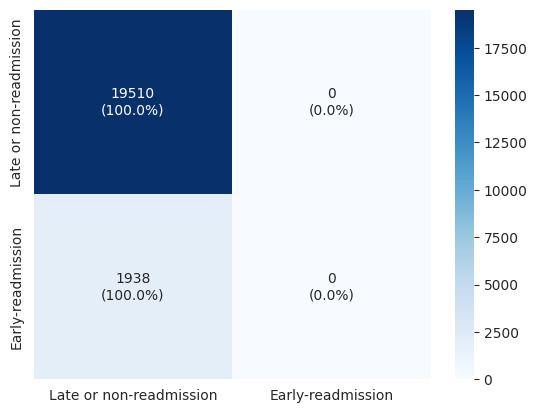

In [64]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [16]:
def objective(trial: optuna.Trial) -> float:
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"]),
        "C": trial.suggest_loguniform("C", 1e-3, 1e3),
        "solver": "saga" if "elasticnet" in trial.params.get("penalty", "") else trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0) if "elasticnet" in trial.params.get("penalty", []) else None,
        "max_iter": 1000
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = LogisticRegression(**params, random_state=RANDOM_STATE)
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [18]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

FileNotFoundError: [Errno 2] No such file or directory: '../optuna/lightgbm/optuna_lightgbm_rus.log'

### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [34]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-07 12:31:59,141] Trial 0 finished with value: 0.4943859689165907 and parameters: {'max_depth': 28, 'min_samples_split': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.4943859689165907.
[I 2025-01-07 12:31:59,315] Trial 2 finished with value: 0.49280094850918343 and parameters: {'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.4943859689165907.


Cross validation scores: [0.48959805 0.48994542 0.5091772  0.49481059 0.48839858]
Average score: 0.4943859689165907
Cross validation scores: [0.48639868 0.49137155 0.50605134 0.49315721 0.48702596]
Average score: 0.49280094850918343
Cross validation scores: [0.48345303 0.48647841 0.50088988 0.49209544 0.4876231 ]
Average score: 0.4901079717787894


[I 2025-01-07 12:31:59,338] Trial 3 finished with value: 0.4901079717787894 and parameters: {'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.4943859689165907.
[I 2025-01-07 12:32:00,882] Trial 1 finished with value: 0.45104254705375385 and parameters: {'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.4943859689165907.


Cross validation scores: [0.4486241  0.45399997 0.46540696 0.44854469 0.43863702]
Average score: 0.45104254705375385


[I 2025-01-07 12:32:01,526] Trial 5 finished with value: 0.5166843535694237 and parameters: {'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.5166843535694237.


Cross validation scores: [0.51030397 0.51672491 0.52610917 0.51725425 0.51302947]
Average score: 0.5166843535694237


[I 2025-01-07 12:32:02,353] Trial 4 finished with value: 0.4944257135196034 and parameters: {'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 5 with value: 0.5166843535694237.


Cross validation scores: [0.48984659 0.49213666 0.50646911 0.49425963 0.48941658]
Average score: 0.4944257135196034


[I 2025-01-07 12:32:03,105] Trial 6 finished with value: 0.482876829825154 and parameters: {'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.5166843535694237.


Cross validation scores: [0.47694835 0.47999244 0.49516399 0.48159219 0.48068718]
Average score: 0.482876829825154


[I 2025-01-07 12:32:04,513] Trial 7 finished with value: 0.48812647830592804 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 5 with value: 0.5166843535694237.


Cross validation scores: [0.48076387 0.48807666 0.49963554 0.49023524 0.48192107]
Average score: 0.48812647830592804


[I 2025-01-07 12:32:05,478] Trial 8 finished with value: 0.4770137924377618 and parameters: {'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 1}. Best is trial 5 with value: 0.5166843535694237.


Cross validation scores: [0.47019058 0.47703386 0.48914491 0.4773519  0.47134772]
Average score: 0.4770137924377618


[I 2025-01-07 12:32:05,717] Trial 10 finished with value: 0.5130078075980661 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.5166843535694237.


Cross validation scores: [0.50629833 0.50581625 0.52810751 0.51399098 0.51082597]
Average score: 0.5130078075980661


[I 2025-01-07 12:32:05,990] Trial 9 finished with value: 0.4866972040262113 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.5166843535694237.


Cross validation scores: [0.48072547 0.48693691 0.49642136 0.48554953 0.48385275]
Average score: 0.4866972040262113


[I 2025-01-07 12:32:08,169] Trial 13 finished with value: 0.5190268869422898 and parameters: {'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 13 with value: 0.5190268869422898.


Cross validation scores: [0.51655216 0.52247272 0.52667821 0.51751673 0.51191462]
Average score: 0.5190268869422898


[I 2025-01-07 12:32:08,423] Trial 11 finished with value: 0.48728315442901493 and parameters: {'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 13 with value: 0.5190268869422898.
[I 2025-01-07 12:32:08,440] Trial 14 finished with value: 0.5190344411238861 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.5190344411238861.


Cross validation scores: [0.48071649 0.48746553 0.49843581 0.48795541 0.48184253]
Average score: 0.48728315442901493
Cross validation scores: [0.51635658 0.52249388 0.52702047 0.51705911 0.51224218]
Average score: 0.5190344411238861


[I 2025-01-07 12:32:08,980] Trial 12 finished with value: 0.5079231968980895 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.5190344411238861.


Cross validation scores: [0.4980163  0.50504328 0.52142162 0.50996049 0.5051743 ]
Average score: 0.5079231968980895


[I 2025-01-07 12:32:10,481] Trial 15 finished with value: 0.5190268869422898 and parameters: {'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 10}. Best is trial 14 with value: 0.5190344411238861.


Cross validation scores: [0.51655216 0.52247272 0.52667821 0.51751673 0.51191462]
Average score: 0.5190268869422898


[I 2025-01-07 12:32:11,257] Trial 18 finished with value: 0.5190344411238861 and parameters: {'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.5190344411238861.


Cross validation scores: [0.51635658 0.52249388 0.52702047 0.51705911 0.51224218]
Average score: 0.5190344411238861


[I 2025-01-07 12:32:11,812] Trial 16 finished with value: 0.5072654438402602 and parameters: {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.5190344411238861.


Cross validation scores: [0.49669464 0.50410398 0.52148755 0.50989606 0.50414499]
Average score: 0.5072654438402602


[I 2025-01-07 12:32:12,075] Trial 17 finished with value: 0.49991580979589123 and parameters: {'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 14 with value: 0.5190344411238861.


Cross validation scores: [0.49388079 0.49503057 0.51545319 0.50128074 0.49393376]
Average score: 0.49991580979589123


[I 2025-01-07 12:32:13,919] Trial 19 finished with value: 0.5028951342893583 and parameters: {'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 10}. Best is trial 14 with value: 0.5190344411238861.


Cross validation scores: [0.49419879 0.49812798 0.51844798 0.50426794 0.49943298]
Average score: 0.5028951342893583


[I 2025-01-07 12:32:14,162] Trial 21 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795
Cross validation scores: [0.50535429 0.50585341 0.52614286 0.51109296 0.50971618]
Average score: 0.5116319415321854


[I 2025-01-07 12:32:14,362] Trial 20 finished with value: 0.5116319415321854 and parameters: {'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.5191716554314795.
[I 2025-01-07 12:32:15,275] Trial 22 finished with value: 0.5131703810134225 and parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.50386925 0.51020111 0.526202   0.51398165 0.51159789]
Average score: 0.5131703810134225


[I 2025-01-07 12:32:16,535] Trial 24 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795


[I 2025-01-07 12:32:17,326] Trial 25 finished with value: 0.5175826196019522 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.5191716554314795.
[I 2025-01-07 12:32:17,499] Trial 23 finished with value: 0.500704304182127 and parameters: {'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.50762009 0.52001481 0.5294163  0.51757802 0.51328388]
Average score: 0.5175826196019522
Cross validation scores: [0.49182371 0.4996195  0.51515252 0.5003407  0.49658509]
Average score: 0.500704304182127


[I 2025-01-07 12:32:18,234] Trial 26 finished with value: 0.5186058629657235 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.50947309 0.5216692  0.52860846 0.51927644 0.51400213]
Average score: 0.5186058629657235


[I 2025-01-07 12:32:19,048] Trial 27 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795


[I 2025-01-07 12:32:20,124] Trial 29 finished with value: 0.5173424002409502 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.50848484 0.51890656 0.52816831 0.51914721 0.51200508]
Average score: 0.5173424002409502


[I 2025-01-07 12:32:20,612] Trial 28 finished with value: 0.5076188009823983 and parameters: {'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.50004989 0.50341546 0.52261119 0.50878593 0.50323154]
Average score: 0.5076188009823983


[I 2025-01-07 12:32:21,604] Trial 30 finished with value: 0.5006961574087819 and parameters: {'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.49232258 0.49668278 0.51405459 0.50426422 0.49615661]
Average score: 0.5006961574087819


[I 2025-01-07 12:32:22,889] Trial 32 finished with value: 0.5141419367599627 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.50487643 0.51081475 0.52781836 0.51676526 0.51043488]
Average score: 0.5141419367599627


[I 2025-01-07 12:32:23,117] Trial 31 finished with value: 0.4762716842585914 and parameters: {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.47064569 0.47839689 0.48470073 0.48005114 0.46756397]
Average score: 0.4762716842585914


[I 2025-01-07 12:32:23,816] Trial 34 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795


[I 2025-01-07 12:32:24,789] Trial 33 finished with value: 0.49129320435755713 and parameters: {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.4830181  0.4891216  0.50488446 0.49294983 0.48649202]
Average score: 0.49129320435755713


[I 2025-01-07 12:32:25,295] Trial 35 finished with value: 0.5190680375143668 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.51582874 0.5228816  0.52674518 0.51725546 0.5126292 ]
Average score: 0.5190680375143668


[I 2025-01-07 12:32:26,054] Trial 36 finished with value: 0.5185506676012779 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.5079147  0.52213566 0.52994756 0.51914841 0.513607  ]
Average score: 0.5185506676012779


[I 2025-01-07 12:32:26,759] Trial 37 finished with value: 0.5175826196019522 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.5191716554314795.


Cross validation scores: [0.50762009 0.52001481 0.5294163  0.51757802 0.51328388]
Average score: 0.5175826196019522


[I 2025-01-07 12:32:27,418] Trial 38 finished with value: 0.519213279769769 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51595898 0.52341303 0.52674518 0.51725546 0.51269374]
Average score: 0.519213279769769


[I 2025-01-07 12:32:28,467] Trial 39 finished with value: 0.5126551681129675 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 38 with value: 0.519213279769769.
[I 2025-01-07 12:32:28,624] Trial 40 finished with value: 0.5190680375143668 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.50578022 0.50736746 0.52422333 0.51528318 0.51062165]
Average score: 0.5126551681129675
Cross validation scores: [0.51582874 0.5228816  0.52674518 0.51725546 0.5126292 ]
Average score: 0.5190680375143668


[I 2025-01-07 12:32:29,567] Trial 41 finished with value: 0.5179624515888974 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.5118288  0.51821631 0.52655859 0.51875667 0.5144519 ]
Average score: 0.5179624515888974


[I 2025-01-07 12:32:30,877] Trial 44 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795


[I 2025-01-07 12:32:31,587] Trial 42 finished with value: 0.4771237833490359 and parameters: {'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.47113605 0.48019342 0.48708843 0.47535911 0.4718419 ]
Average score: 0.4771237833490359


[I 2025-01-07 12:32:31,799] Trial 43 finished with value: 0.5079231968980895 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 38 with value: 0.519213279769769.
[I 2025-01-07 12:32:31,928] Trial 45 finished with value: 0.5190680375143668 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.4980163  0.50504328 0.52142162 0.50996049 0.5051743 ]
Average score: 0.5079231968980895
Cross validation scores: [0.51582874 0.5228816  0.52674518 0.51725546 0.5126292 ]
Average score: 0.5190680375143668


[I 2025-01-07 12:32:33,657] Trial 46 finished with value: 0.5185506676012779 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.5079147  0.52213566 0.52994756 0.51914841 0.513607  ]
Average score: 0.5185506676012779


[I 2025-01-07 12:32:34,158] Trial 48 finished with value: 0.5189813864312555 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51543108 0.52301439 0.52683912 0.51686406 0.51275829]
Average score: 0.5189813864312555


[I 2025-01-07 12:32:34,667] Trial 47 finished with value: 0.5127343846890565 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.50475345 0.50717507 0.52646966 0.51347773 0.51179602]
Average score: 0.5127343846890565


[I 2025-01-07 12:32:35,767] Trial 49 finished with value: 0.4885544735596901 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.48345303 0.48789791 0.49878103 0.48799916 0.48464124]
Average score: 0.4885544735596901


[I 2025-01-07 12:32:36,335] Trial 50 finished with value: 0.5175826196019522 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.50762009 0.52001481 0.5294163  0.51757802 0.51328388]
Average score: 0.5175826196019522


[I 2025-01-07 12:32:36,989] Trial 52 finished with value: 0.5190680375143668 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51582874 0.5228816  0.52674518 0.51725546 0.5126292 ]
Average score: 0.5190680375143668


[I 2025-01-07 12:32:37,969] Trial 51 finished with value: 0.4910799820620976 and parameters: {'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.48685436 0.48664448 0.50361295 0.4917961  0.48649202]
Average score: 0.4910799820620976


[I 2025-01-07 12:32:38,918] Trial 54 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795
Cross validation scores: [0.50383451 0.51011071 0.52688645 0.51446557 0.51294147]
Average score: 0.5136477426531885


[I 2025-01-07 12:32:39,118] Trial 53 finished with value: 0.5136477426531885 and parameters: {'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 38 with value: 0.519213279769769.
[I 2025-01-07 12:32:39,578] Trial 55 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795


[I 2025-01-07 12:32:40,966] Trial 56 finished with value: 0.5175826196019522 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.50762009 0.52001481 0.5294163  0.51757802 0.51328388]
Average score: 0.5175826196019522


[I 2025-01-07 12:32:41,447] Trial 57 finished with value: 0.5190680375143668 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51582874 0.5228816  0.52674518 0.51725546 0.5126292 ]
Average score: 0.5190680375143668


[I 2025-01-07 12:32:42,056] Trial 58 finished with value: 0.5186058629657235 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.50947309 0.5216692  0.52860846 0.51927644 0.51400213]
Average score: 0.5186058629657235


[I 2025-01-07 12:32:42,811] Trial 59 finished with value: 0.5127343846890565 and parameters: {'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.50475345 0.50717507 0.52646966 0.51347773 0.51179602]
Average score: 0.5127343846890565


[I 2025-01-07 12:32:43,367] Trial 60 finished with value: 0.5190680375143668 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51582874 0.5228816  0.52674518 0.51725546 0.5126292 ]
Average score: 0.5190680375143668


[I 2025-01-07 12:32:44,803] Trial 62 finished with value: 0.5179556082840598 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 38 with value: 0.519213279769769.
[I 2025-01-07 12:32:44,896] Trial 61 finished with value: 0.5079231968980895 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51027374 0.51780906 0.52893152 0.51888796 0.51387576]
Average score: 0.5179556082840598
Cross validation scores: [0.4980163  0.50504328 0.52142162 0.50996049 0.5051743 ]
Average score: 0.5079231968980895


[I 2025-01-07 12:32:45,676] Trial 64 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795


[I 2025-01-07 12:32:47,253] Trial 65 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.
[I 2025-01-07 12:32:47,310] Trial 66 finished with value: 0.5190680375143668 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795
Cross validation scores: [0.51582874 0.5228816  0.52674518 0.51725546 0.5126292 ]
Average score: 0.5190680375143668


[I 2025-01-07 12:32:47,485] Trial 63 finished with value: 0.46759437781379576 and parameters: {'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.46382721 0.46834128 0.47720741 0.46943941 0.45915657]
Average score: 0.46759437781379576


[I 2025-01-07 12:32:48,546] Trial 67 finished with value: 0.5175826196019522 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.50762009 0.52001481 0.5294163  0.51757802 0.51328388]
Average score: 0.5175826196019522


[I 2025-01-07 12:32:49,882] Trial 68 finished with value: 0.5192123233635715 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51649319 0.52267176 0.52687916 0.51758186 0.51243565]
Average score: 0.5192123233635715


[I 2025-01-07 12:32:50,382] Trial 69 finished with value: 0.5185488952515152 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51061397 0.51888866 0.53061865 0.51888688 0.51373632]
Average score: 0.5185488952515152


[I 2025-01-07 12:32:50,703] Trial 70 finished with value: 0.5127504919013038 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.50524804 0.50730622 0.52672946 0.51336741 0.51110133]
Average score: 0.5127504919013038


[I 2025-01-07 12:32:50,992] Trial 71 finished with value: 0.5190680375143668 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51582874 0.5228816  0.52674518 0.51725546 0.5126292 ]
Average score: 0.5190680375143668


[I 2025-01-07 12:32:53,184] Trial 74 finished with value: 0.5191716554314795 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.519213279769769.


Cross validation scores: [0.51614738 0.52347951 0.52647737 0.51706028 0.51269374]
Average score: 0.5191716554314795


[I 2025-01-07 12:32:53,400] Trial 75 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.
[I 2025-01-07 12:32:53,501] Trial 72 finished with value: 0.49790755528929853 and parameters: {'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 75 with value: 0.5192656112151862.
[I 2025-01-07 12:32:53,516] Trial 73 finished with value: 0.5130078075980661 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862
Cross validation scores: [0.49061773 0.49241327 0.51214811 0.5007001  0.49365857]
Average score: 0.49790755528929853
Cross validation scores: [0.50629833 0.50581625 0.52810751 0.51399098 0.51082597]
Average score: 0.5130078075980661


[I 2025-01-07 12:32:56,031] Trial 77 finished with value: 0.5190833969377314 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 75 with value: 0.5192656112151862.
[I 2025-01-07 12:32:56,133] Trial 76 finished with value: 0.5172385830219395 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 75 with value: 0.5192656112151862.
[I 2025-01-07 12:32:56,206] Trial 79 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51642801 0.5228045  0.52675942 0.51705911 0.51236595]
Average score: 0.5190833969377314
Cross validation scores: [0.51125828 0.51659348 0.52719909 0.51856056 0.51258151]
Average score: 0.5172385830219395
Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:32:56,509] Trial 78 finished with value: 0.5172385830219395 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51125828 0.51659348 0.52719909 0.51856056 0.51258151]
Average score: 0.5172385830219395


[I 2025-01-07 12:32:58,649] Trial 82 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:32:58,856] Trial 80 finished with value: 0.5182474006322746 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51109238 0.51756616 0.52928153 0.51980391 0.51349303]
Average score: 0.5182474006322746


[I 2025-01-07 12:32:59,316] Trial 83 finished with value: 0.5178433436194915 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51053589 0.51605462 0.5292731  0.51941011 0.513943  ]
Average score: 0.5178433436194915


[I 2025-01-07 12:33:00,529] Trial 81 finished with value: 0.48102316492020825 and parameters: {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.47584551 0.47971834 0.49235131 0.48100158 0.47619908]
Average score: 0.48102316492020825


[I 2025-01-07 12:33:01,217] Trial 84 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.
[I 2025-01-07 12:33:01,399] Trial 85 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862
Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:33:02,053] Trial 86 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:33:03,486] Trial 87 finished with value: 0.5179556082840598 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51027374 0.51780906 0.52893152 0.51888796 0.51387576]
Average score: 0.5179556082840598


[I 2025-01-07 12:33:03,837] Trial 88 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.
[I 2025-01-07 12:33:03,977] Trial 89 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862
Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:33:05,168] Trial 90 finished with value: 0.5136477426531885 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.50383451 0.51011071 0.52688645 0.51446557 0.51294147]
Average score: 0.5136477426531885


[I 2025-01-07 12:33:06,264] Trial 92 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862
Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:33:06,460] Trial 93 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.
[I 2025-01-07 12:33:07,622] Trial 94 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:33:08,739] Trial 95 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:33:09,120] Trial 96 finished with value: 0.5186058629657235 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.50947309 0.5216692  0.52860846 0.51927644 0.51400213]
Average score: 0.5186058629657235


[I 2025-01-07 12:33:09,650] Trial 91 finished with value: 0.44168675896379456 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.43639193 0.44583638 0.45302565 0.44192401 0.43125582]
Average score: 0.44168675896379456


[I 2025-01-07 12:33:09,945] Trial 97 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:33:10,498] Trial 98 finished with value: 0.5192656112151862 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51614738 0.52347951 0.52675249 0.51719039 0.51275829]
Average score: 0.5192656112151862


[I 2025-01-07 12:33:10,812] Trial 99 finished with value: 0.5178433436194915 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 75 with value: 0.5192656112151862.


Cross validation scores: [0.51053589 0.51605462 0.5292731  0.51941011 0.513943  ]
Average score: 0.5178433436194915


In [35]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 75
Best Parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}
Best Value: 0.5192656112151862


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [36]:
optuna.visualization.plot_optimization_history(study)

In [37]:
optuna.visualization.plot_slice(study)

In [38]:
optuna.visualization.plot_param_importances(study)

In [39]:
optuna.visualization.plot_parallel_coordinate(study)

In [40]:
optuna.visualization.plot_contour(study)

In [41]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [42]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    LogisticRegression(**best_params, random_state=RANDOM_STATE, max_iter=500)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_depth=4, min_samples_leaf=2,
                                      min_samples_split=4, random_state=38))])

In [43]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [44]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.7007892896393246
Test accuracy:  0.6988530399104812


In [45]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.72      0.81     19510
      Early-readmission       0.14      0.47      0.22      1938

               accuracy                           0.70     21448
              macro avg       0.54      0.59      0.52     21448
           weighted avg       0.86      0.70      0.76     21448



In [46]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

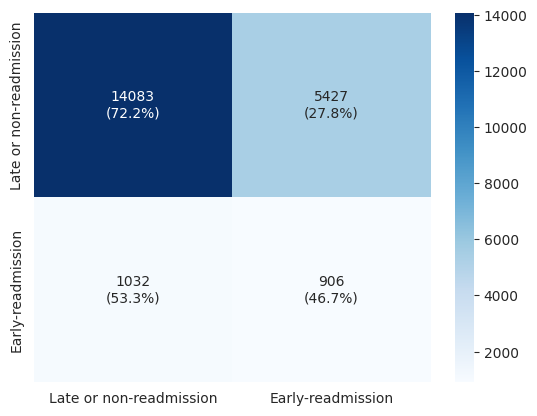

In [47]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [48]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"]),
        "C": trial.suggest_loguniform("C", 1e-3, 1e3),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0) if "elasticnet" in trial.params.get("penalty", []) else None
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        LogisticRegression(**params, random_state=RANDOM_STATE, max_iter=500)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [49]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/usr/local/python/3.12.1/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-07 12:33:12,147] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [50]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-07 12:33:28,391] Trial 0 finished with value: 0.5273605060654201 and parameters: {'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.5273605060654201.


Cross validation scores: [0.52128879 0.52816669 0.53707976 0.5270801  0.52318719]
Average score: 0.5273605060654201


[I 2025-01-07 12:33:30,166] Trial 2 finished with value: 0.5283908001822277 and parameters: {'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.5283908001822277.


Cross validation scores: [0.52339502 0.53015741 0.53838292 0.52879374 0.52122492]
Average score: 0.5283908001822277


[I 2025-01-07 12:33:32,565] Trial 1 finished with value: 0.5314162664461712 and parameters: {'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.5314162664461712.


Cross validation scores: [0.52751836 0.5352675  0.53960332 0.53239283 0.52229931]
Average score: 0.5314162664461712


[I 2025-01-07 12:33:35,399] Trial 3 finished with value: 0.5355977840177197 and parameters: {'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.5355977840177197.


Cross validation scores: [0.53239758 0.53863574 0.54604901 0.53542924 0.52547735]
Average score: 0.5355977840177197


[I 2025-01-07 12:33:40,122] Trial 5 finished with value: 0.5206533868213048 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.5355977840177197.


Cross validation scores: [0.5191687  0.52360206 0.52694617 0.51973888 0.51381112]
Average score: 0.5206533868213048


[I 2025-01-07 12:33:49,999] Trial 4 finished with value: 0.5356894525980189 and parameters: {'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.5356894525980189.


Cross validation scores: [0.53329517 0.53985011 0.54392648 0.53483691 0.52653859]
Average score: 0.5356894525980189


[I 2025-01-07 12:33:52,195] Trial 7 finished with value: 0.5294553183395895 and parameters: {'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.5356894525980189.


Cross validation scores: [0.52534247 0.53280894 0.53515598 0.52934946 0.52461974]
Average score: 0.5294553183395895


[I 2025-01-07 12:33:54,009] Trial 6 finished with value: 0.5351307053039754 and parameters: {'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.5356894525980189.


Cross validation scores: [0.5310689  0.54107696 0.54131254 0.5363782  0.52581692]
Average score: 0.5351307053039754


[I 2025-01-07 12:33:59,604] Trial 8 finished with value: 0.5336526659713214 and parameters: {'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.5356894525980189.


Cross validation scores: [0.53046125 0.53834181 0.54051498 0.53177914 0.52716615]
Average score: 0.5336526659713214


[I 2025-01-07 12:34:02,343] Trial 9 finished with value: 0.5194193028915304 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.5356894525980189.


Cross validation scores: [0.51568203 0.52102554 0.5260147  0.51796414 0.51641011]
Average score: 0.5194193028915304


[I 2025-01-07 12:34:13,323] Trial 11 finished with value: 0.5293882649764139 and parameters: {'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.5356894525980189.


Cross validation scores: [0.52500433 0.53508763 0.53655675 0.52832833 0.52196427]
Average score: 0.5293882649764139


[I 2025-01-07 12:34:19,988] Trial 12 finished with value: 0.5343187832219238 and parameters: {'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.5356894525980189.


Cross validation scores: [0.53261962 0.53971273 0.54145435 0.53285012 0.52495708]
Average score: 0.5343187832219238


[I 2025-01-07 12:34:20,418] Trial 10 finished with value: 0.5290361924858681 and parameters: {'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.5356894525980189.


Cross validation scores: [0.52538913 0.5315038  0.53680314 0.5293136  0.52217129]
Average score: 0.5290361924858681


[I 2025-01-07 12:34:24,634] Trial 13 finished with value: 0.5361490640910014 and parameters: {'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.5361490640910014.


Cross validation scores: [0.531523   0.54306263 0.54086369 0.53556831 0.52972769]
Average score: 0.5361490640910014


[I 2025-01-07 12:34:36,615] Trial 14 finished with value: 0.5378676430069208 and parameters: {'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53482622 0.5469299  0.54192281 0.53745129 0.52820799]
Average score: 0.5378676430069208


[I 2025-01-07 12:34:42,208] Trial 16 finished with value: 0.5372299130159723 and parameters: {'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53373372 0.54114746 0.54249144 0.53618896 0.53258798]
Average score: 0.5372299130159723


[I 2025-01-07 12:34:43,608] Trial 15 finished with value: 0.5343536089920071 and parameters: {'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53470132 0.54052876 0.53606736 0.53314521 0.5273254 ]
Average score: 0.5343536089920071


[I 2025-01-07 12:34:47,146] Trial 17 finished with value: 0.5363335207376518 and parameters: {'max_depth': 24, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53626806 0.54157937 0.54118531 0.53635909 0.52627577]
Average score: 0.5363335207376518


[I 2025-01-07 12:34:51,140] Trial 20 finished with value: 0.5194553753658935 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.51791743 0.52344654 0.52617141 0.51672997 0.51301151]
Average score: 0.5194553753658935


[I 2025-01-07 12:35:00,092] Trial 18 finished with value: 0.5353899638599389 and parameters: {'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53345112 0.53714302 0.54219629 0.53489856 0.52926083]
Average score: 0.5353899638599389


[I 2025-01-07 12:35:02,713] Trial 19 finished with value: 0.5335988164264505 and parameters: {'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53218877 0.53665313 0.54014332 0.53346452 0.52554434]
Average score: 0.5335988164264505


[I 2025-01-07 12:35:06,165] Trial 21 finished with value: 0.5327992851945156 and parameters: {'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53010213 0.53708626 0.54136437 0.53136094 0.52408273]
Average score: 0.5327992851945156


[I 2025-01-07 12:35:13,213] Trial 22 finished with value: 0.5354792565395237 and parameters: {'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.5333823  0.54028856 0.54308248 0.53405415 0.52658881]
Average score: 0.5354792565395237


[I 2025-01-07 12:35:14,931] Trial 23 finished with value: 0.5245139352226527 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.52027803 0.52645979 0.53404938 0.52006859 0.52171388]
Average score: 0.5245139352226527


[I 2025-01-07 12:35:26,982] Trial 25 finished with value: 0.5364698592310801 and parameters: {'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.5341438  0.53895552 0.54336664 0.53644731 0.52943602]
Average score: 0.5364698592310801


[I 2025-01-07 12:35:27,367] Trial 24 finished with value: 0.5345560127298941 and parameters: {'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.5342687  0.53249551 0.53862679 0.53747642 0.52991265]
Average score: 0.5345560127298941


[I 2025-01-07 12:35:36,435] Trial 27 finished with value: 0.5368597447137673 and parameters: {'max_depth': 24, 'min_samples_split': 14, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.5378676430069208.
[I 2025-01-07 12:35:36,534] Trial 26 finished with value: 0.5359820399001397 and parameters: {'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53185124 0.54221359 0.54355136 0.53791909 0.52876345]
Average score: 0.5368597447137673
Cross validation scores: [0.53033905 0.54278762 0.54140829 0.53589307 0.52948217]
Average score: 0.5359820399001397


[I 2025-01-07 12:35:46,650] Trial 28 finished with value: 0.5359300673903065 and parameters: {'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53477215 0.54129421 0.54616278 0.53001798 0.52740322]
Average score: 0.5359300673903065


[I 2025-01-07 12:35:47,778] Trial 29 finished with value: 0.5335740957811743 and parameters: {'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.52988918 0.53650161 0.54122867 0.53373004 0.52652098]
Average score: 0.5335740957811743


[I 2025-01-07 12:35:57,026] Trial 31 finished with value: 0.5328178097612405 and parameters: {'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.52979764 0.53834604 0.53986378 0.53180218 0.5242794 ]
Average score: 0.5328178097612405


[I 2025-01-07 12:35:58,281] Trial 30 finished with value: 0.5349071250657256 and parameters: {'max_depth': 26, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53083071 0.53681641 0.54277024 0.53541038 0.52870788]
Average score: 0.5349071250657256


[I 2025-01-07 12:36:07,155] Trial 32 finished with value: 0.5360274140302268 and parameters: {'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.5337357  0.5419968  0.54550058 0.53471607 0.52418791]
Average score: 0.5360274140302268


[I 2025-01-07 12:36:09,522] Trial 33 finished with value: 0.5348971586976358 and parameters: {'max_depth': 26, 'min_samples_split': 18, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53182573 0.53903732 0.5412075  0.53430654 0.52810871]
Average score: 0.5348971586976358


[I 2025-01-07 12:36:16,687] Trial 35 finished with value: 0.5318524616713919 and parameters: {'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.5271141  0.53705338 0.54408102 0.52755879 0.52345501]
Average score: 0.5318524616713919


[I 2025-01-07 12:36:18,504] Trial 34 finished with value: 0.5364698592310801 and parameters: {'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.5341438  0.53895552 0.54336664 0.53644731 0.52943602]
Average score: 0.5364698592310801


[I 2025-01-07 12:36:27,689] Trial 36 finished with value: 0.5355700312593275 and parameters: {'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53284143 0.54104387 0.54234052 0.53502401 0.52660033]
Average score: 0.5355700312593275


[I 2025-01-07 12:36:32,349] Trial 37 finished with value: 0.5362121461944902 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53381242 0.54160784 0.54020496 0.53890852 0.526527  ]
Average score: 0.5362121461944902


[I 2025-01-07 12:36:34,564] Trial 38 finished with value: 0.5307665093585099 and parameters: {'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.52693302 0.53373529 0.53831571 0.53190533 0.5229432 ]
Average score: 0.5307665093585099


[I 2025-01-07 12:36:38,395] Trial 39 finished with value: 0.5312885385849301 and parameters: {'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 9}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.5270251  0.5350217  0.53856183 0.53135292 0.52448115]
Average score: 0.5312885385849301


[I 2025-01-07 12:36:48,444] Trial 40 finished with value: 0.5361838572068386 and parameters: {'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53723944 0.53966361 0.54078646 0.5342074  0.52902238]
Average score: 0.5361838572068386


[I 2025-01-07 12:36:53,696] Trial 42 finished with value: 0.5354615974065757 and parameters: {'max_depth': 16, 'min_samples_split': 19, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53212119 0.54159996 0.54220457 0.53285367 0.5285286 ]
Average score: 0.5354615974065757


[I 2025-01-07 12:36:54,440] Trial 41 finished with value: 0.5356894525980189 and parameters: {'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53329517 0.53985011 0.54392648 0.53483691 0.52653859]
Average score: 0.5356894525980189


[I 2025-01-07 12:37:01,354] Trial 43 finished with value: 0.5351355978257996 and parameters: {'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53576628 0.53742865 0.53943784 0.53652227 0.52652295]
Average score: 0.5351355978257996


[I 2025-01-07 12:37:09,698] Trial 44 finished with value: 0.5364698592310801 and parameters: {'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.5341438  0.53895552 0.54336664 0.53644731 0.52943602]
Average score: 0.5364698592310801


[I 2025-01-07 12:37:13,937] Trial 45 finished with value: 0.5342989038812309 and parameters: {'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53196832 0.53886679 0.53981158 0.53263464 0.52821319]
Average score: 0.5342989038812309


[I 2025-01-07 12:37:15,971] Trial 46 finished with value: 0.5367474293181711 and parameters: {'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53024993 0.54295394 0.54347347 0.5393571  0.52770271]
Average score: 0.5367474293181711


[I 2025-01-07 12:37:23,627] Trial 47 finished with value: 0.5374648795595414 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53623081 0.5429393  0.54273196 0.5387291  0.52669324]
Average score: 0.5374648795595414


[I 2025-01-07 12:37:34,050] Trial 49 finished with value: 0.5340343144704256 and parameters: {'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.52847591 0.54112855 0.54205049 0.53176201 0.52675462]
Average score: 0.5340343144704256


[I 2025-01-07 12:37:34,418] Trial 48 finished with value: 0.5326552711525772 and parameters: {'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53071792 0.53322725 0.54097263 0.53503817 0.52332039]
Average score: 0.5326552711525772


[I 2025-01-07 12:37:37,859] Trial 50 finished with value: 0.5359298796446144 and parameters: {'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53427295 0.54169827 0.54022107 0.53336336 0.53009375]
Average score: 0.5359298796446144


[I 2025-01-07 12:37:51,275] Trial 51 finished with value: 0.5268184395048421 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.52769245 0.52423532 0.53116912 0.53190368 0.51909163]
Average score: 0.5268184395048421


[I 2025-01-07 12:37:56,866] Trial 52 finished with value: 0.535776983711408 and parameters: {'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53457689 0.53721509 0.54317729 0.53651354 0.52740211]
Average score: 0.535776983711408


[I 2025-01-07 12:37:57,916] Trial 53 finished with value: 0.5342184001718661 and parameters: {'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53470132 0.5394685  0.53859311 0.53459477 0.5237343 ]
Average score: 0.5342184001718661


[I 2025-01-07 12:38:00,434] Trial 54 finished with value: 0.5354374418728518 and parameters: {'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.5378676430069208.


Cross validation scores: [0.53070901 0.540144   0.54351267 0.53293242 0.5298891 ]
Average score: 0.5354374418728518


[I 2025-01-07 12:38:13,151] Trial 55 finished with value: 0.5387906710887692 and parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53712011 0.54352934 0.54563731 0.53621466 0.53145194]
Average score: 0.5387906710887692


[I 2025-01-07 12:38:17,366] Trial 57 finished with value: 0.5343068879054317 and parameters: {'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 5}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53423925 0.53746209 0.54112408 0.53025996 0.52844906]
Average score: 0.5343068879054317


[I 2025-01-07 12:38:18,875] Trial 56 finished with value: 0.5372998832160741 and parameters: {'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53548779 0.5375905  0.54704945 0.53897822 0.52739345]
Average score: 0.5372998832160741


[I 2025-01-07 12:38:21,592] Trial 58 finished with value: 0.5348281081601147 and parameters: {'max_depth': 24, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53068906 0.54079545 0.54145435 0.53339224 0.52780944]
Average score: 0.5348281081601147


[I 2025-01-07 12:38:35,381] Trial 59 finished with value: 0.5387906710887692 and parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53712011 0.54352934 0.54563731 0.53621466 0.53145194]
Average score: 0.5387906710887692


[I 2025-01-07 12:38:35,882] Trial 61 finished with value: 0.5289899820998404 and parameters: {'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52733838 0.53200192 0.53533001 0.52526409 0.5250155 ]
Average score: 0.5289899820998404


[I 2025-01-07 12:38:43,566] Trial 62 finished with value: 0.5375948436227828 and parameters: {'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53149872 0.54234467 0.54350896 0.53800244 0.53261942]
Average score: 0.5375948436227828


[I 2025-01-07 12:38:43,993] Trial 60 finished with value: 0.5300089464045203 and parameters: {'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52763325 0.53060429 0.53848028 0.53318299 0.52014392]
Average score: 0.5300089464045203


[I 2025-01-07 12:38:52,454] Trial 63 finished with value: 0.5271059847543814 and parameters: {'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52344215 0.52937257 0.53590726 0.52628717 0.52052078]
Average score: 0.5271059847543814


[I 2025-01-07 12:38:57,690] Trial 64 finished with value: 0.5359446683496188 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53163947 0.5419886  0.54064155 0.53562404 0.52982968]
Average score: 0.5359446683496188


[I 2025-01-07 12:39:04,236] Trial 66 finished with value: 0.5354600557473062 and parameters: {'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53493228 0.53751162 0.54453563 0.53269324 0.52762751]
Average score: 0.5354600557473062


[I 2025-01-07 12:39:05,424] Trial 65 finished with value: 0.5375948436227828 and parameters: {'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53149872 0.54234467 0.54350896 0.53800244 0.53261942]
Average score: 0.5375948436227828


[I 2025-01-07 12:39:10,133] Trial 68 finished with value: 0.5196693740207385 and parameters: {'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.51595607 0.52052328 0.52600482 0.51895287 0.51690983]
Average score: 0.5196693740207385


[I 2025-01-07 12:39:15,884] Trial 67 finished with value: 0.5369222638954283 and parameters: {'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53384444 0.5382008  0.54700057 0.53773566 0.52782984]
Average score: 0.5369222638954283


[I 2025-01-07 12:39:24,894] Trial 70 finished with value: 0.5326116986051148 and parameters: {'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52941585 0.53514754 0.5407949  0.53370613 0.52399407]
Average score: 0.5326116986051148


[I 2025-01-07 12:39:26,527] Trial 69 finished with value: 0.536985952793135 and parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53239937 0.54430389 0.54073187 0.53868436 0.52881027]
Average score: 0.536985952793135


[I 2025-01-07 12:39:31,822] Trial 71 finished with value: 0.5366266563739099 and parameters: {'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53276984 0.53738353 0.54818376 0.53582111 0.52897505]
Average score: 0.5366266563739099


[I 2025-01-07 12:39:39,261] Trial 72 finished with value: 0.5338071317268962 and parameters: {'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53054236 0.5402376  0.5428785  0.53192846 0.52344875]
Average score: 0.5338071317268962


[I 2025-01-07 12:39:45,782] Trial 73 finished with value: 0.5354600557473062 and parameters: {'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53493228 0.53751162 0.54453563 0.53269324 0.52762751]
Average score: 0.5354600557473062


[I 2025-01-07 12:39:47,911] Trial 74 finished with value: 0.5363312870430086 and parameters: {'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53209485 0.54261071 0.54262331 0.53453436 0.5297932 ]
Average score: 0.5363312870430086


[I 2025-01-07 12:39:53,517] Trial 75 finished with value: 0.5374648795595414 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53623081 0.5429393  0.54273196 0.5387291  0.52669324]
Average score: 0.5374648795595414


[I 2025-01-07 12:39:55,420] Trial 78 finished with value: 0.5194360824982599 and parameters: {'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.51804163 0.52388872 0.52570285 0.51666489 0.51288232]
Average score: 0.5194360824982599


[I 2025-01-07 12:39:59,556] Trial 76 finished with value: 0.5337852142429369 and parameters: {'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53098368 0.53605547 0.54177528 0.53296508 0.52714657]
Average score: 0.5337852142429369


[I 2025-01-07 12:40:07,787] Trial 77 finished with value: 0.5359446683496188 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53163947 0.5419886  0.54064155 0.53562404 0.52982968]
Average score: 0.5359446683496188


[I 2025-01-07 12:40:12,420] Trial 79 finished with value: 0.5307443120514694 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52697588 0.53425237 0.53874298 0.52951681 0.52423352]
Average score: 0.5307443120514694


[I 2025-01-07 12:40:16,512] Trial 80 finished with value: 0.5361838572068386 and parameters: {'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53723944 0.53966361 0.54078646 0.5342074  0.52902238]
Average score: 0.5361838572068386


[I 2025-01-07 12:40:18,724] Trial 81 finished with value: 0.5327810652215612 and parameters: {'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52782935 0.53674834 0.54172004 0.53149694 0.52611066]
Average score: 0.5327810652215612


[I 2025-01-07 12:40:30,313] Trial 82 finished with value: 0.537101785071587 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53102462 0.54336917 0.54707689 0.53522809 0.52881015]
Average score: 0.537101785071587


[I 2025-01-07 12:40:34,433] Trial 83 finished with value: 0.5362753515979461 and parameters: {'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53523794 0.53924631 0.54458966 0.53496879 0.52733406]
Average score: 0.5362753515979461


[I 2025-01-07 12:40:38,549] Trial 84 finished with value: 0.5374648795595414 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53623081 0.5429393  0.54273196 0.5387291  0.52669324]
Average score: 0.5374648795595414


[I 2025-01-07 12:40:40,586] Trial 85 finished with value: 0.5363312870430086 and parameters: {'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53209485 0.54261071 0.54262331 0.53453436 0.5297932 ]
Average score: 0.5363312870430086


[I 2025-01-07 12:40:53,678] Trial 86 finished with value: 0.5362121461944902 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53381242 0.54160784 0.54020496 0.53890852 0.526527  ]
Average score: 0.5362121461944902


[I 2025-01-07 12:40:56,108] Trial 87 finished with value: 0.5359556576425641 and parameters: {'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53309078 0.54109175 0.54144239 0.5351226  0.52903077]
Average score: 0.5359556576425641


[I 2025-01-07 12:41:00,100] Trial 89 finished with value: 0.5314794687351191 and parameters: {'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 8}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53068454 0.534875   0.53988746 0.52995854 0.52199181]
Average score: 0.5314794687351191


[I 2025-01-07 12:41:01,468] Trial 88 finished with value: 0.5363603024364262 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53586927 0.5375701  0.54088987 0.53669493 0.53077735]
Average score: 0.5363603024364262


[I 2025-01-07 12:41:19,455] Trial 90 finished with value: 0.5325853647532991 and parameters: {'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52838936 0.53317983 0.54184182 0.53251066 0.52700515]
Average score: 0.5325853647532991


[I 2025-01-07 12:41:21,460] Trial 92 finished with value: 0.5371907601243222 and parameters: {'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52946662 0.54298041 0.5465386  0.53458386 0.53238431]
Average score: 0.5371907601243222


[I 2025-01-07 12:41:22,009] Trial 91 finished with value: 0.5300089464045203 and parameters: {'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.52763325 0.53060429 0.53848028 0.53318299 0.52014392]
Average score: 0.5300089464045203


[I 2025-01-07 12:41:23,372] Trial 93 finished with value: 0.5368107751803842 and parameters: {'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53520963 0.5406773  0.54214472 0.53383044 0.53219179]
Average score: 0.5368107751803842


[I 2025-01-07 12:41:41,501] Trial 94 finished with value: 0.5372778722873746 and parameters: {'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53607596 0.54354521 0.54210334 0.53335103 0.53131383]
Average score: 0.5372778722873746


[I 2025-01-07 12:41:43,123] Trial 95 finished with value: 0.5359556576425641 and parameters: {'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53309078 0.54109175 0.54144239 0.5351226  0.52903077]
Average score: 0.5359556576425641


[I 2025-01-07 12:41:43,612] Trial 96 finished with value: 0.5351082718307054 and parameters: {'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53134717 0.53928608 0.54156838 0.53802814 0.52531159]
Average score: 0.5351082718307054


[I 2025-01-07 12:41:44,466] Trial 97 finished with value: 0.5377012753439429 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53529015 0.54560517 0.54450922 0.53476048 0.52834136]
Average score: 0.5377012753439429


[I 2025-01-07 12:41:58,071] Trial 98 finished with value: 0.5361490640910014 and parameters: {'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.531523   0.54306263 0.54086369 0.53556831 0.52972769]
Average score: 0.5361490640910014


[I 2025-01-07 12:41:59,069] Trial 99 finished with value: 0.5374648795595414 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 55 with value: 0.5387906710887692.


Cross validation scores: [0.53623081 0.5429393  0.54273196 0.5387291  0.52669324]
Average score: 0.5374648795595414


In [51]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 55
Best Parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 3}
Best Value: 0.5387906710887692


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [52]:
optuna.visualization.plot_optimization_history(study)

In [53]:
optuna.visualization.plot_slice(study)

In [54]:
optuna.visualization.plot_param_importances(study)

In [55]:
optuna.visualization.plot_parallel_coordinate(study)

In [56]:
optuna.visualization.plot_contour(study)

In [57]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [58]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    LogisticRegression(**best_params, random_state=RANDOM_STATE, max_iter=500)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_depth=20, min_samples_leaf=3,
                                      min_samples_split=16, random_state=38))])

In [59]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [60]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.8453391947247477
Test accuracy:  0.7873927638940694


In [61]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.84      0.88     19510
      Early-readmission       0.14      0.27      0.19      1938

               accuracy                           0.79     21448
              macro avg       0.53      0.56      0.53     21448
           weighted avg       0.85      0.79      0.82     21448



In [62]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

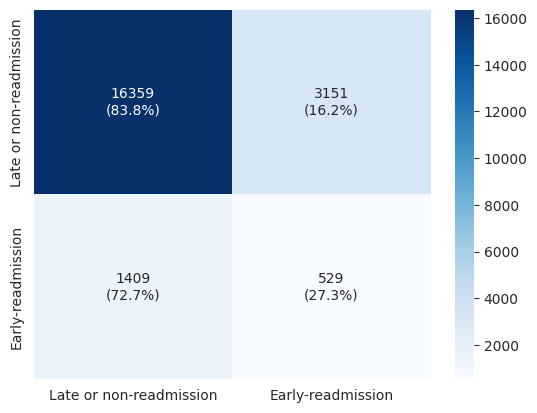

In [63]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [64]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"]),
        "C": trial.suggest_loguniform("C", 1e-3, 1e3),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0) if "elasticnet" in trial.params.get("penalty", []) else None
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        LogisticRegression(**params, random_state=RANDOM_STATE, max_iter=500)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [65]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/usr/local/python/3.12.1/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-07 12:42:04,729] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [66]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-07 12:42:50,177] Trial 2 finished with value: 0.5179941868868443 and parameters: {'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.5179941868868443.


Cross validation scores: [0.51322316 0.51898659 0.52802209 0.51477229 0.51496681]
Average score: 0.5179941868868443


[I 2025-01-07 12:42:58,462] Trial 1 finished with value: 0.5318394966440093 and parameters: {'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.5318394966440093.


Cross validation scores: [0.52953828 0.5343279  0.54026041 0.53081226 0.52425864]
Average score: 0.5318394966440093


[I 2025-01-07 12:43:01,482] Trial 0 finished with value: 0.5367257765094282 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.53331985 0.54115147 0.54433118 0.5357976  0.52902878]
Average score: 0.5367257765094282


[I 2025-01-07 12:43:01,859] Trial 3 finished with value: 0.5326909392741496 and parameters: {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52759162 0.53641879 0.54008302 0.53630512 0.52305614]
Average score: 0.5326909392741496


[I 2025-01-07 12:43:43,210] Trial 4 finished with value: 0.5326615466806465 and parameters: {'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52866189 0.53634619 0.54110395 0.52999628 0.52719943]
Average score: 0.5326615466806465


[I 2025-01-07 12:43:47,535] Trial 5 finished with value: 0.528671507147495 and parameters: {'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52637222 0.53170721 0.5369152  0.52622312 0.52213978]
Average score: 0.528671507147495


[I 2025-01-07 12:43:50,620] Trial 7 finished with value: 0.5257058355609214 and parameters: {'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52108777 0.52564549 0.53413486 0.52706989 0.52059118]
Average score: 0.5257058355609214


[I 2025-01-07 12:43:57,664] Trial 6 finished with value: 0.5351671272350152 and parameters: {'max_depth': 24, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.53134853 0.54251048 0.54035268 0.53446569 0.52715826]
Average score: 0.5351671272350152


[I 2025-01-07 12:44:27,086] Trial 9 finished with value: 0.5179187999523878 and parameters: {'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.5165794  0.5210089  0.52415522 0.51601204 0.51183844]
Average score: 0.5179187999523878


[I 2025-01-07 12:44:36,112] Trial 8 finished with value: 0.5300972692353056 and parameters: {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52824971 0.53312308 0.53672906 0.53032158 0.52206291]
Average score: 0.5300972692353056


[I 2025-01-07 12:44:42,654] Trial 10 finished with value: 0.5323746182222321 and parameters: {'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.53223048 0.53145598 0.54268615 0.52899816 0.52650233]
Average score: 0.5323746182222321


[I 2025-01-07 12:44:52,172] Trial 11 finished with value: 0.5332195493093177 and parameters: {'max_depth': 24, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.53014958 0.5379238  0.53923025 0.52944674 0.52934737]
Average score: 0.5332195493093177


[I 2025-01-07 12:45:17,505] Trial 12 finished with value: 0.5308370806652393 and parameters: {'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52751407 0.5335335  0.54225361 0.52652022 0.52436401]
Average score: 0.5308370806652393


[I 2025-01-07 12:45:31,519] Trial 13 finished with value: 0.5352084777227922 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52894123 0.53931655 0.54383364 0.5347091  0.52924187]
Average score: 0.5352084777227922


[I 2025-01-07 12:45:36,834] Trial 14 finished with value: 0.5356090908812124 and parameters: {'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52919347 0.54117571 0.54387713 0.53396618 0.52983297]
Average score: 0.5356090908812124


[I 2025-01-07 12:45:48,024] Trial 15 finished with value: 0.5362460869622739 and parameters: {'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.53131502 0.54232188 0.54343253 0.53822324 0.52593776]
Average score: 0.5362460869622739


[I 2025-01-07 12:46:10,168] Trial 16 finished with value: 0.5304931708978635 and parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52843354 0.53455832 0.53918978 0.52794911 0.52233511]
Average score: 0.5304931708978635


[I 2025-01-07 12:46:25,337] Trial 17 finished with value: 0.5351293157517085 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.5295805  0.54316426 0.54384441 0.5303773  0.52868011]
Average score: 0.5351293157517085


[I 2025-01-07 12:46:35,312] Trial 18 finished with value: 0.5311977510003317 and parameters: {'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.52970657 0.53440746 0.53455799 0.53456268 0.52275405]
Average score: 0.5311977510003317


[I 2025-01-07 12:46:45,941] Trial 19 finished with value: 0.5348088358450181 and parameters: {'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.53361344 0.5363774  0.54004257 0.53663578 0.527375  ]
Average score: 0.5348088358450181


[I 2025-01-07 12:46:56,681] Trial 20 finished with value: 0.5226575028983941 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.51796686 0.52083781 0.53231907 0.52050217 0.5216616 ]
Average score: 0.5226575028983941


[I 2025-01-07 12:47:25,069] Trial 21 finished with value: 0.5324640650686564 and parameters: {'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.53372423 0.53064185 0.53968869 0.53433197 0.52393359]
Average score: 0.5324640650686564


[I 2025-01-07 12:47:32,861] Trial 22 finished with value: 0.5345756740015346 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5367257765094282.


Cross validation scores: [0.53121197 0.53688223 0.54133553 0.53270221 0.53074643]
Average score: 0.5345756740015346


[I 2025-01-07 12:47:44,491] Trial 23 finished with value: 0.5368647201684962 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.5368647201684962.


Cross validation scores: [0.53396764 0.54139409 0.54398627 0.53515897 0.52981663]
Average score: 0.5368647201684962


[I 2025-01-07 12:47:50,870] Trial 24 finished with value: 0.5364454306157175 and parameters: {'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.5368647201684962.


Cross validation scores: [0.53324408 0.53869301 0.54426012 0.53468278 0.53134717]
Average score: 0.5364454306157175


[I 2025-01-07 12:48:22,963] Trial 25 finished with value: 0.5335094320137561 and parameters: {'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.5368647201684962.


Cross validation scores: [0.52826184 0.5419229  0.53889459 0.5326205  0.52584734]
Average score: 0.5335094320137561


[I 2025-01-07 12:48:30,304] Trial 26 finished with value: 0.5372658884571759 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53309414 0.53740282 0.54381716 0.53860789 0.53340743]
Average score: 0.5372658884571759


[I 2025-01-07 12:48:39,047] Trial 27 finished with value: 0.5312070546981165 and parameters: {'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52874706 0.53509494 0.54000355 0.52859321 0.52359651]
Average score: 0.5312070546981165


[I 2025-01-07 12:48:47,009] Trial 28 finished with value: 0.535512413574998 and parameters: {'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53436896 0.53563002 0.53843641 0.53817065 0.53095603]
Average score: 0.535512413574998


[I 2025-01-07 12:49:16,663] Trial 29 finished with value: 0.5319719318047186 and parameters: {'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52811741 0.53665313 0.53724225 0.53341295 0.52443392]
Average score: 0.5319719318047186


[I 2025-01-07 12:49:23,873] Trial 30 finished with value: 0.5372658884571759 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53309414 0.53740282 0.54381716 0.53860789 0.53340743]
Average score: 0.5372658884571759


[I 2025-01-07 12:49:35,991] Trial 31 finished with value: 0.5356235657403361 and parameters: {'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53096766 0.53873108 0.54366439 0.53405539 0.5306993 ]
Average score: 0.5356235657403361


[I 2025-01-07 12:49:38,502] Trial 32 finished with value: 0.5315013350144098 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52887356 0.53177887 0.53956324 0.53137781 0.52591321]
Average score: 0.5315013350144098


[I 2025-01-07 12:50:02,330] Trial 33 finished with value: 0.5173275294420016 and parameters: {'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.51381779 0.51879802 0.52408939 0.51578836 0.51414409]
Average score: 0.5173275294420016


[I 2025-01-07 12:50:18,699] Trial 34 finished with value: 0.5372658884571759 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53309414 0.53740282 0.54381716 0.53860789 0.53340743]
Average score: 0.5372658884571759


[I 2025-01-07 12:50:30,029] Trial 36 finished with value: 0.533209058773803 and parameters: {'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53184664 0.5356547  0.53987406 0.53213381 0.52653608]
Average score: 0.533209058773803


[I 2025-01-07 12:50:33,092] Trial 35 finished with value: 0.5349336133462902 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53401677 0.53558831 0.54328778 0.53423492 0.52754028]
Average score: 0.5349336133462902


[I 2025-01-07 12:51:02,493] Trial 37 finished with value: 0.5234843235653808 and parameters: {'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52291457 0.52359413 0.52873491 0.52777813 0.51439987]
Average score: 0.5234843235653808


[I 2025-01-07 12:51:11,465] Trial 38 finished with value: 0.5372658884571759 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53309414 0.53740282 0.54381716 0.53860789 0.53340743]
Average score: 0.5372658884571759


[I 2025-01-07 12:51:22,648] Trial 39 finished with value: 0.53612777349466 and parameters: {'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53321946 0.53968406 0.54493872 0.53477288 0.52802375]
Average score: 0.53612777349466


[I 2025-01-07 12:51:30,844] Trial 40 finished with value: 0.5314246333909021 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53148453 0.52937097 0.53820693 0.53432811 0.52373262]
Average score: 0.5314246333909021


[I 2025-01-07 12:51:55,701] Trial 41 finished with value: 0.5293526795154258 and parameters: {'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52539274 0.53069594 0.5403482  0.52925475 0.52107176]
Average score: 0.5293526795154258


[I 2025-01-07 12:52:01,944] Trial 42 finished with value: 0.5341224731580642 and parameters: {'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52830546 0.54038324 0.5416226  0.53237422 0.52792685]
Average score: 0.5341224731580642


[I 2025-01-07 12:52:13,164] Trial 43 finished with value: 0.5296108310475569 and parameters: {'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 9}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52653355 0.53181812 0.5368415  0.52988668 0.52297431]
Average score: 0.5296108310475569


[I 2025-01-07 12:52:27,025] Trial 44 finished with value: 0.534929040736021 and parameters: {'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53049508 0.53933095 0.53994662 0.5352415  0.52963105]
Average score: 0.534929040736021


[I 2025-01-07 12:52:51,540] Trial 45 finished with value: 0.534815863942576 and parameters: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52871705 0.53917476 0.54181915 0.53632143 0.52804693]
Average score: 0.534815863942576


[I 2025-01-07 12:52:58,895] Trial 46 finished with value: 0.5286513390407857 and parameters: {'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52584173 0.52887021 0.53562905 0.53210376 0.52081194]
Average score: 0.5286513390407857


[I 2025-01-07 12:53:05,736] Trial 47 finished with value: 0.5354556887166898 and parameters: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53049965 0.53924642 0.54311031 0.53732818 0.52709388]
Average score: 0.5354556887166898


[I 2025-01-07 12:53:26,029] Trial 48 finished with value: 0.534195094734205 and parameters: {'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53246193 0.53357416 0.54291334 0.53548243 0.52654361]
Average score: 0.534195094734205


[I 2025-01-07 12:53:43,634] Trial 49 finished with value: 0.5307592926578847 and parameters: {'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52858281 0.53319155 0.53899032 0.52650753 0.52652425]
Average score: 0.5307592926578847


[I 2025-01-07 12:53:57,951] Trial 50 finished with value: 0.5275382785268632 and parameters: {'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52578242 0.52811941 0.53323613 0.52938228 0.52117115]
Average score: 0.5275382785268632


[I 2025-01-07 12:53:58,899] Trial 51 finished with value: 0.5349857089486539 and parameters: {'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53196981 0.54080774 0.54523877 0.53156133 0.5253509 ]
Average score: 0.5349857089486539


[I 2025-01-07 12:54:21,176] Trial 52 finished with value: 0.5340391172614906 and parameters: {'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52967988 0.54005718 0.54138389 0.53462002 0.52445462]
Average score: 0.5340391172614906


[I 2025-01-07 12:54:37,886] Trial 55 finished with value: 0.5175402333497433 and parameters: {'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.51577128 0.52013609 0.52407624 0.51587912 0.51183844]
Average score: 0.5175402333497433
Cross validation scores: [0.52918286 0.53818814 0.54382054 0.53141049 0.52527365]
Average score: 0.5335751362066345


[I 2025-01-07 12:54:38,088] Trial 53 finished with value: 0.5335751362066345 and parameters: {'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.
[I 2025-01-07 12:54:50,405] Trial 54 finished with value: 0.5363406382338771 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.5330835  0.54077857 0.54196376 0.53476814 0.53110923]
Average score: 0.5363406382338771


[I 2025-01-07 12:55:14,632] Trial 56 finished with value: 0.5324003679335492 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53112819 0.53588242 0.54003501 0.53013264 0.52482358]
Average score: 0.5324003679335492


[I 2025-01-07 12:55:28,268] Trial 57 finished with value: 0.5331825276771252 and parameters: {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52964742 0.53846458 0.5433223  0.52792082 0.52655751]
Average score: 0.5331825276771252


[I 2025-01-07 12:55:32,297] Trial 58 finished with value: 0.5348289171298803 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53076615 0.53855334 0.53904333 0.5358251  0.52995667]
Average score: 0.5348289171298803


[I 2025-01-07 12:55:38,696] Trial 59 finished with value: 0.52638386296385 and parameters: {'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52437325 0.527526   0.53393399 0.52488906 0.52119701]
Average score: 0.52638386296385


[I 2025-01-07 12:56:08,565] Trial 60 finished with value: 0.5293185852834149 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52400075 0.5344481  0.53531326 0.53305987 0.51977095]
Average score: 0.5293185852834149


[I 2025-01-07 12:56:21,606] Trial 61 finished with value: 0.534980568547899 and parameters: {'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53195726 0.53818848 0.54151982 0.53461886 0.52861842]
Average score: 0.534980568547899


[I 2025-01-07 12:56:28,137] Trial 62 finished with value: 0.5319953214753979 and parameters: {'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53143097 0.52886566 0.54141969 0.53351737 0.52474291]
Average score: 0.5319953214753979


[I 2025-01-07 12:56:31,846] Trial 63 finished with value: 0.5342320613876932 and parameters: {'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53186361 0.53924416 0.53944535 0.53366766 0.52693954]
Average score: 0.5342320613876932


[I 2025-01-07 12:57:05,157] Trial 64 finished with value: 0.5354860043346938 and parameters: {'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52973217 0.54121159 0.54267984 0.53743703 0.52636939]
Average score: 0.5354860043346938


[I 2025-01-07 12:57:14,437] Trial 65 finished with value: 0.5337730929802339 and parameters: {'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52983551 0.5383949  0.53996826 0.53073139 0.52993541]
Average score: 0.5337730929802339


[I 2025-01-07 12:57:19,320] Trial 66 finished with value: 0.5339278445793779 and parameters: {'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53115906 0.53843469 0.54037328 0.52961297 0.53005922]
Average score: 0.5339278445793779


[I 2025-01-07 12:57:27,109] Trial 67 finished with value: 0.5346703050539718 and parameters: {'max_depth': 24, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53495154 0.53688056 0.53923902 0.53444242 0.52783798]
Average score: 0.5346703050539718


[I 2025-01-07 12:58:01,895] Trial 68 finished with value: 0.5356731376803687 and parameters: {'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53210201 0.54413716 0.54010752 0.5348954  0.5271236 ]
Average score: 0.5356731376803687


[I 2025-01-07 12:58:08,004] Trial 69 finished with value: 0.5330114243842925 and parameters: {'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53272588 0.53495721 0.53817572 0.53207068 0.52712763]
Average score: 0.5330114243842925


[I 2025-01-07 12:58:13,653] Trial 70 finished with value: 0.5354415112777109 and parameters: {'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53427295 0.53680472 0.54208381 0.53448411 0.52956197]
Average score: 0.5354415112777109


[I 2025-01-07 12:58:20,148] Trial 71 finished with value: 0.5361437615401692 and parameters: {'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.5322473  0.54163164 0.54372448 0.53672414 0.52639125]
Average score: 0.5361437615401692


[I 2025-01-07 12:58:58,162] Trial 73 finished with value: 0.5312070546981165 and parameters: {'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52874706 0.53509494 0.54000355 0.52859321 0.52359651]
Average score: 0.5312070546981165


[I 2025-01-07 12:59:00,389] Trial 72 finished with value: 0.5320464357075492 and parameters: {'max_depth': 26, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53098785 0.53180845 0.53662602 0.53555465 0.5252552 ]
Average score: 0.5320464357075492


[I 2025-01-07 12:59:07,242] Trial 74 finished with value: 0.5363406382338771 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.5330835  0.54077857 0.54196376 0.53476814 0.53110923]
Average score: 0.5363406382338771


[I 2025-01-07 12:59:12,232] Trial 75 finished with value: 0.5363406382338771 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.5330835  0.54077857 0.54196376 0.53476814 0.53110923]
Average score: 0.5363406382338771


[I 2025-01-07 12:59:49,139] Trial 76 finished with value: 0.534980568547899 and parameters: {'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53195726 0.53818848 0.54151982 0.53461886 0.52861842]
Average score: 0.534980568547899


[I 2025-01-07 12:59:57,376] Trial 77 finished with value: 0.5344562804896598 and parameters: {'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53571787 0.53551604 0.53947505 0.53477823 0.52679421]
Average score: 0.5344562804896598


[I 2025-01-07 13:00:00,660] Trial 78 finished with value: 0.5356419526319796 and parameters: {'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53114424 0.54106589 0.54251262 0.53533193 0.52815507]
Average score: 0.5356419526319796


[I 2025-01-07 13:00:04,119] Trial 79 finished with value: 0.5348289171298803 and parameters: {'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53076615 0.53855334 0.53904333 0.5358251  0.52995667]
Average score: 0.5348289171298803


[I 2025-01-07 13:00:44,714] Trial 80 finished with value: 0.5314246333909021 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53148453 0.52937097 0.53820693 0.53432811 0.52373262]
Average score: 0.5314246333909021


[I 2025-01-07 13:00:52,374] Trial 81 finished with value: 0.5363717689581092 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53469234 0.5391464  0.54585792 0.53311168 0.52905051]
Average score: 0.5363717689581092


[I 2025-01-07 13:00:56,629] Trial 82 finished with value: 0.5345547481259751 and parameters: {'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53519733 0.53392975 0.54006313 0.53405376 0.52952977]
Average score: 0.5345547481259751


[I 2025-01-07 13:01:01,839] Trial 83 finished with value: 0.5266473163817478 and parameters: {'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52430663 0.52454045 0.5351585  0.52882863 0.52040237]
Average score: 0.5266473163817478


[I 2025-01-07 13:01:38,075] Trial 84 finished with value: 0.5363406382338771 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.5330835  0.54077857 0.54196376 0.53476814 0.53110923]
Average score: 0.5363406382338771


[I 2025-01-07 13:01:47,492] Trial 85 finished with value: 0.5363717689581092 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53469234 0.5391464  0.54585792 0.53311168 0.52905051]
Average score: 0.5363717689581092


[I 2025-01-07 13:01:51,763] Trial 86 finished with value: 0.5363717689581092 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53469234 0.5391464  0.54585792 0.53311168 0.52905051]
Average score: 0.5363717689581092


[I 2025-01-07 13:01:52,475] Trial 87 finished with value: 0.5328598803189133 and parameters: {'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52931305 0.53666018 0.54135692 0.53015178 0.52681747]
Average score: 0.5328598803189133


[I 2025-01-07 13:02:32,335] Trial 88 finished with value: 0.5340678856482816 and parameters: {'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53308804 0.53630559 0.54280403 0.5317852  0.52635658]
Average score: 0.5340678856482816


[I 2025-01-07 13:02:44,610] Trial 89 finished with value: 0.5344012068170109 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53122645 0.53572054 0.54391248 0.53278724 0.52835933]
Average score: 0.5344012068170109


[I 2025-01-07 13:02:45,619] Trial 91 finished with value: 0.5351854975202555 and parameters: {'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53195762 0.54074273 0.54520754 0.53196234 0.52605725]
Average score: 0.5351854975202555


[I 2025-01-07 13:02:48,276] Trial 90 finished with value: 0.5348043050162266 and parameters: {'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53122766 0.5381741  0.54346275 0.53386097 0.52729604]
Average score: 0.5348043050162266


[I 2025-01-07 13:03:30,195] Trial 92 finished with value: 0.5289559549549374 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52970708 0.52923031 0.53467085 0.53261917 0.51855237]
Average score: 0.5289559549549374


[I 2025-01-07 13:03:40,544] Trial 94 finished with value: 0.5363717689581092 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53469234 0.5391464  0.54585792 0.53311168 0.52905051]
Average score: 0.5363717689581092


[I 2025-01-07 13:03:42,095] Trial 93 finished with value: 0.535486352310993 and parameters: {'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52915817 0.53865566 0.5448662  0.53679633 0.5279554 ]
Average score: 0.535486352310993


[I 2025-01-07 13:03:45,729] Trial 95 finished with value: 0.534815863942576 and parameters: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52871705 0.53917476 0.54181915 0.53632143 0.52804693]
Average score: 0.534815863942576


[I 2025-01-07 13:04:20,811] Trial 96 finished with value: 0.5292082088027794 and parameters: {'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.52612554 0.53041585 0.54012015 0.52496185 0.52441765]
Average score: 0.5292082088027794


[I 2025-01-07 13:04:31,878] Trial 97 finished with value: 0.5361994812634323 and parameters: {'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53650068 0.53787433 0.54055134 0.53537267 0.53069838]
Average score: 0.5361994812634323


[I 2025-01-07 13:04:34,724] Trial 98 finished with value: 0.5344809140015079 and parameters: {'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53148462 0.53970688 0.54448716 0.52928971 0.52743619]
Average score: 0.5344809140015079


[I 2025-01-07 13:04:36,632] Trial 99 finished with value: 0.533997411399552 and parameters: {'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5372658884571759.


Cross validation scores: [0.53477823 0.53621591 0.5376256  0.53502297 0.52634434]
Average score: 0.533997411399552


In [67]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 26
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2}
Best Value: 0.5372658884571759


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [68]:
optuna.visualization.plot_optimization_history(study)

In [69]:
optuna.visualization.plot_slice(study)

In [70]:
optuna.visualization.plot_param_importances(study)

In [71]:
optuna.visualization.plot_parallel_coordinate(study)

In [72]:
optuna.visualization.plot_contour(study)

In [73]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [74]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    LogisticRegression(**best_params, random_state=RANDOM_STATE, max_iter=500)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_depth=20, min_samples_leaf=2,
                                      min_samples_split=10, random_state=38))])

In [75]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [76]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.8693775601958238
Test accuracy:  0.8002144722118613


In [77]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.86      0.89     19510
      Early-readmission       0.14      0.24      0.18      1938

               accuracy                           0.80     21448
              macro avg       0.53      0.55      0.53     21448
           weighted avg       0.85      0.80      0.82     21448



In [78]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

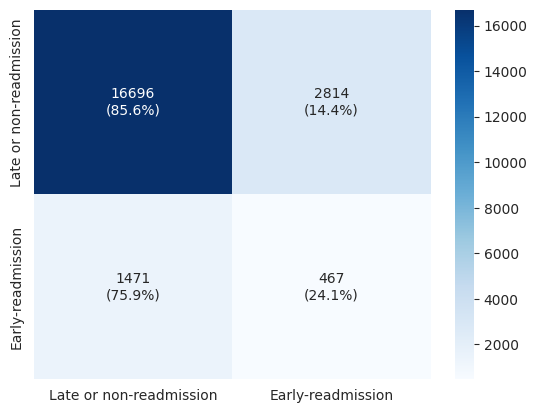

In [79]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

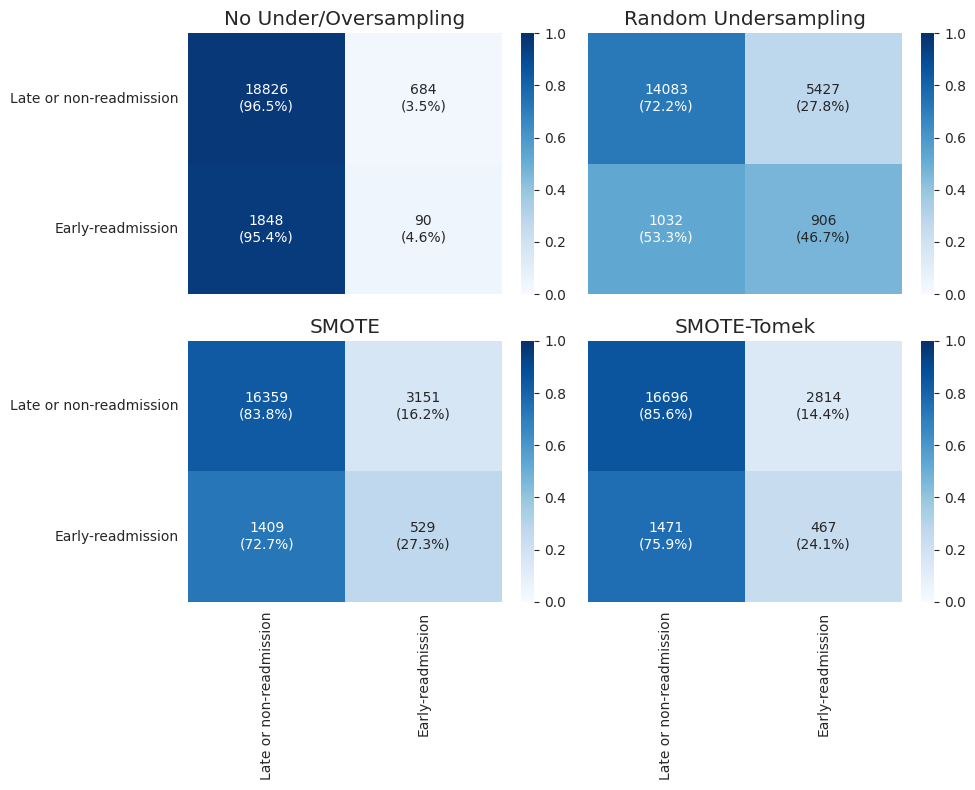

In [80]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [81]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.505690,0.513446,0.501681,0.505690,0.881947
Random Undersampling,0.594664,0.537392,0.516269,0.594664,0.698853
SMOTE,0.555727,0.532225,0.533000,0.555727,0.787393
SMOTE-Tomek,0.548368,0.530682,0.532616,0.548368,0.800214


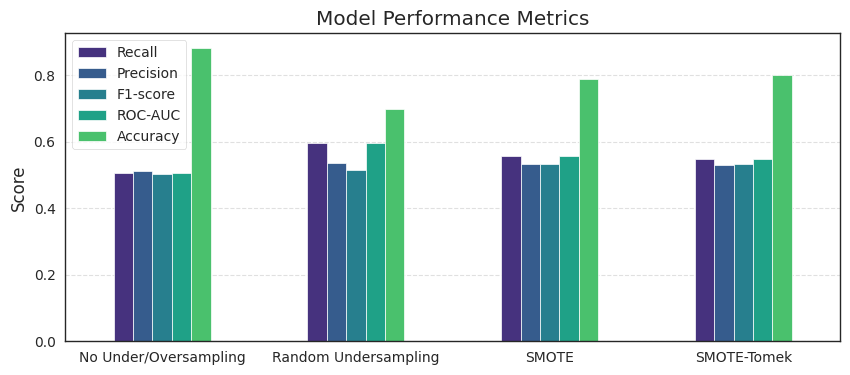

In [82]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()